In [1]:
import torch
from ch4 import GPTModel

GPT_CONGIG_124M = {
        "vocab_size":     50257,  # Vocabulary size
        "context_length": 256,    # Context length
        "emb_dim":        768,    # Embedding dimension
        "n_heads":        12,     # Number of attention heads
        "n_layers":       12,     # Number of layers
        "drop_rate":      0.1,    # Dropout rate
        "qkv_bias":       False   # Query-Key-Value bias
    }
torch.manual_seed(123)
model = GPTModel(GPT_CONGIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
import tiktoken
from ch4 import generate_text_simple

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)   # Removes the batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONGIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [3]:
inputs = torch.tensor([
    [16833,3626,6100],
    [40,1107,588]
])
targets = torch.tensor([
    [3626,6100,345],
    [1107,588,11311]
])
print("inputs:\n",token_ids_to_text(inputs[0].unsqueeze(0),tokenizer),"\n",token_ids_to_text(inputs[1].unsqueeze(0),tokenizer))
print("targets:\n",token_ids_to_text(targets[0].unsqueeze(0),tokenizer),"\n",token_ids_to_text(targets[1].unsqueeze(0),tokenizer))

inputs:
 every effort moves 
 I really like
targets:
  effort moves you 
  really like chocolate


In [4]:
with torch.no_grad():
    logits = model(inputs)                  # 1.求出logits
probas = torch.softmax(logits,dim=-1)       # 2.求出所有Probabilities
print(probas.shape)
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print("Token IDs:\n",token_ids)
print(f"Targets batch 1:{token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1:{token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1: effort moves you
Outputs batch 1: Armed heNetflix


In [5]:
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]   # 3.求出目标的probability
print("Text 1:",target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]   # 3.求出目标的probability
print("Text 2:",target_probas_2)

log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))   # 4.求出log的probability
print(log_probas)

avg_log_probas = torch.mean(log_probas)    # 5.求出平均的probability
print(avg_log_probas)

neg_avg_log_probas = -avg_log_probas      # 6.求负的，结果是一个entrop loss
print(neg_avg_log_probas)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


In [6]:
print("Logits shape:",logits.shape)
print("Targets shape:",targets.shape)

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits shape:",logits_flat.shape)
print("Flattened targets shape:",targets_flat.shape)
print("Flattened logits:\n",logits_flat)
print("Flattened targets:\n",targets_flat)

loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print("Entropy loss:",loss)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])
Flattened logits:
 tensor([[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
        [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
        [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217],
        [-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
        [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
        [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]])
Flattened targets:
 tensor([ 3626,  6100,   345,  1107,   588, 11311])
Entropy loss: tensor(10.7940)


In [7]:
file_path = "the-verdict.txt"
with open(file_path,"r",encoding='utf-8') as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:",total_characters)
print("Tokens:",total_tokens)

Characters: 20479
Tokens: 5145


In [8]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

from ch2 import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONGIG_124M["context_length"],
    stride=GPT_CONGIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONGIG_124M["context_length"],
    stride=GPT_CONGIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
)
print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape,y.shape)


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


c:\Users\liuhz\Desktop\files\projects\LLM\Chapter5\ch2.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input_ids[idx]),torch.tensor(self.target_ids[idx])


In [9]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss

In [10]:
def calc_loss_loader(data_loader,model,device,num_batchs=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batchs is None:
        num_batchs = len(data_loader)
    else:
        num_batchs = min(num_batchs,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batchs:
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batchs

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 10.98758316040039
Validation loss: 10.98110580444336


In [13]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batchs=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batchs=eval_iter)
    model.train()
    return train_loss,val_loss

In [14]:
def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx = encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [15]:
def train_model_simple(model,train_loader,val_loader,
                       optimizer,device,num_epochs,
                       eval_freq,eval_iter,start_context,tokenizer):
    train_losses,val_losses,track_tokens_seen = [],[],[]
    tokens_seen,global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss,val_loss = evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        
        generate_and_print_sample(
            model,tokenizer,device,start_context
        )
    
    return train_losses,val_losses,track_tokens_seen

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONGIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay=0.1
)
num_epochs = 10
train_losses,val_losses,tokens_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context="Every effort moves you",tokenizer=tokenizer
)

c:\Users\liuhz\Desktop\files\projects\LLM\Chapter5\ch2.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input_ids[idx]),torch.tensor(self.target_ids[idx])


Ep 1 (Step 000000): Train loss 9.823, Val loss 9.932
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.621, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.043, Val loss 6.599
Every effort moves you, and,, and,, and,,,, and, and,,,,,,,,, and,,,, the,,,, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.547, Val loss 6.485
Ep 3 (Step 000025): Train loss 5.450, Val loss 6.397
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.982, Val loss 6.301
Ep 4 (Step 000035): Train loss 4.755, Val loss 6.296
Every effort moves you, and I had been the of the picture to the picture.                                     
Ep 5 (Step 000040): Train loss 4.162, Val loss 6.182
Every effort moves you know the                                                

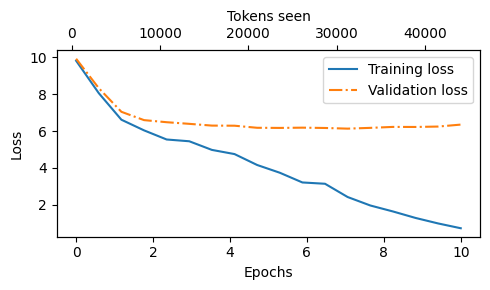

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
    fig,ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label="Training loss")
    ax1.plot(epochs_seen,val_losses,linestyle="-.",label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen,train_losses,alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

In [19]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONGIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [21]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits,_ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx,idx_next),dim=1)
    
    return idx


In [22]:
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONGIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you know began to happen. It was not it was such not to see her


In [ ]:
#save
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [26]:
#load
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONGIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-4,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

C:\Users\liuhz\AppData\Local\Temp\ipykernel_4576\3979599727.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth",map_locatio

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features